In [ ]:
claims =  read.table(".../claims.txt", header=TRUE)
claims$cmsinistros = claims$csinistros/claims$nsinistros
library(MASS)
library(dglm)

Warning message:
"package 'dglm' was built under R version 4.4.3"


### Unindo níveis

In [3]:
claims$areac[claims$areac == "A"] = "ABC"
claims$areac[claims$areac == "B"] = "ABC"
claims$areac[claims$areac == "C"] = "ABC"
claims$areac[claims$areac == "D"] = "DEF"
claims$areac[claims$areac == "E"] = "DEF"
claims$areac[claims$areac == "F"] = "DEF"
areac = factor(claims$areac)

In [4]:
claims$idadec[claims$idadec == 1] = "1+2"
claims$idadec[claims$idadec == 2] = "1+2"
claims$idadec[claims$idadec == 3] = "3+4+5+6"
claims$idadec[claims$idadec == 4] = "3+4+5+6"
claims$idadec[claims$idadec == 5] = "3+4+5+6"
claims$idadec[claims$idadec == 6] = "3+4+5+6"
idadec = factor(claims$idadec)

In [5]:
claims$tipov[claims$tipov == "SEDAN"] = "PASSEIO"
claims$tipov[claims$tipov == "STNWG"] = "PASSEIO"
claims$tipov[claims$tipov == "COUPE"] = "PASSEIO"
claims$tipov[claims$tipov == "HBACK"] = "PASSEIO"

claims$tipov[claims$tipov == "BUS"] = "TRAB"
claims$tipov[claims$tipov == "MIBUS"] = "TRAB"
claims$tipov[claims$tipov == "HDTOP"] = "TRAB"
claims$tipov[claims$tipov == "MCARA"] = "TRAB"
claims$tipov[claims$tipov == "PANVN"] = "TRAB"
claims$tipov[claims$tipov == "TRUCK"] = "TRAB"
claims$tipov[claims$tipov == "UTE"] = "TRAB"


In [6]:
tipov = factor(claims$tipov)
expos = claims$expos
sexoc = factor(claims$sexoc)
idadev = factor(claims$idadev)
cmsinistros = claims$cmsinistros
valorv = claims$valorv

# Modelo Simples

In [544]:
fit.model = glm(cmsinistros ~  tipov+areac+expos, family=inverse.gaussian(link=log), data=claims)

summary(fit.model)



Call:
glm(formula = cmsinistros ~ tipov + areac + expos, family = inverse.gaussian(link = log), 
    data = claims)

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   7.9904     0.1442  55.411  < 2e-16 ***
tipovTRAB     0.3391     0.1547   2.192   0.0286 *  
areacDEF      0.1573     0.1121   1.404   0.1607    
expos        -1.0979     0.1968  -5.578 3.14e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for inverse.gaussian family taken to be 0.001356867)

    Null deviance: 1.4367  on 995  degrees of freedom
Residual deviance: 1.3754  on 992  degrees of freedom
AIC: 16288

Number of Fisher Scoring iterations: 9


### Análise de Diagnóstico

In [310]:
X <- model.matrix(fit.model)
n <- nrow(X)
p <- ncol(X)
w <- fit.model$weights
W <- diag(w)
H <- solve(t(X)%*%W%*%X)
H <- sqrt(W)%*%X%*%H%*%t(X)%*%sqrt(W)
h <- diag(H)
soma <- resid(fit.model, type="pearson")
soma <- sum(soma^2)
fi <- (n-p)/soma
ts <- resid(fit.model,type="pearson")*sqrt(fi/(1-h))
td <- resid(fit.model,type="deviance")*sqrt(fi/(1-h))
par(mfrow=c(2,2))
di <- (h/(1-h))*(ts^2)
a <- max(td)
b <- min(td)

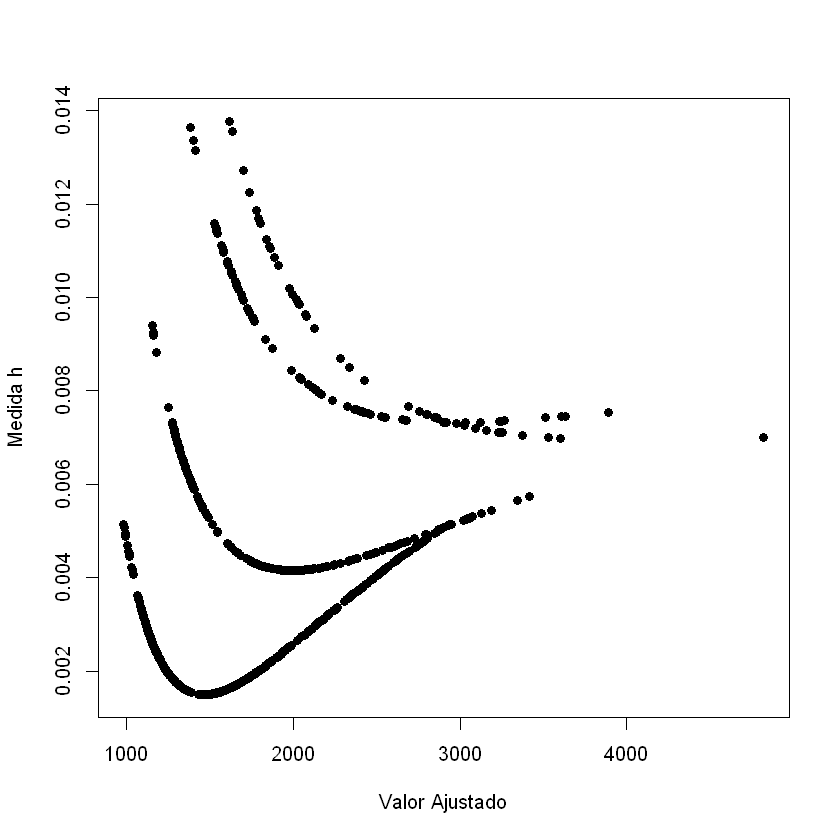

In [ ]:
par(bg = "white")
plot(fitted(fit.model),h,xlab="Valor Ajustado", ylab="Medida h", pch=16)

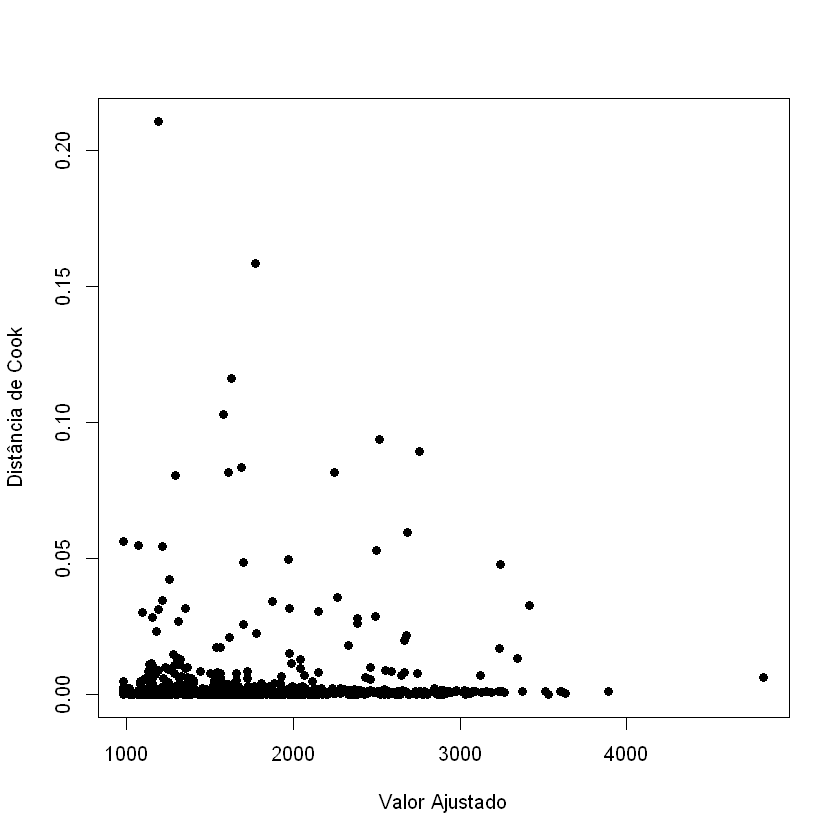

In [312]:
par(bg = 'white')
plot(fitted(fit.model), di,xlab="Valor Ajustado", ylab="Distância de Cook", pch=16)

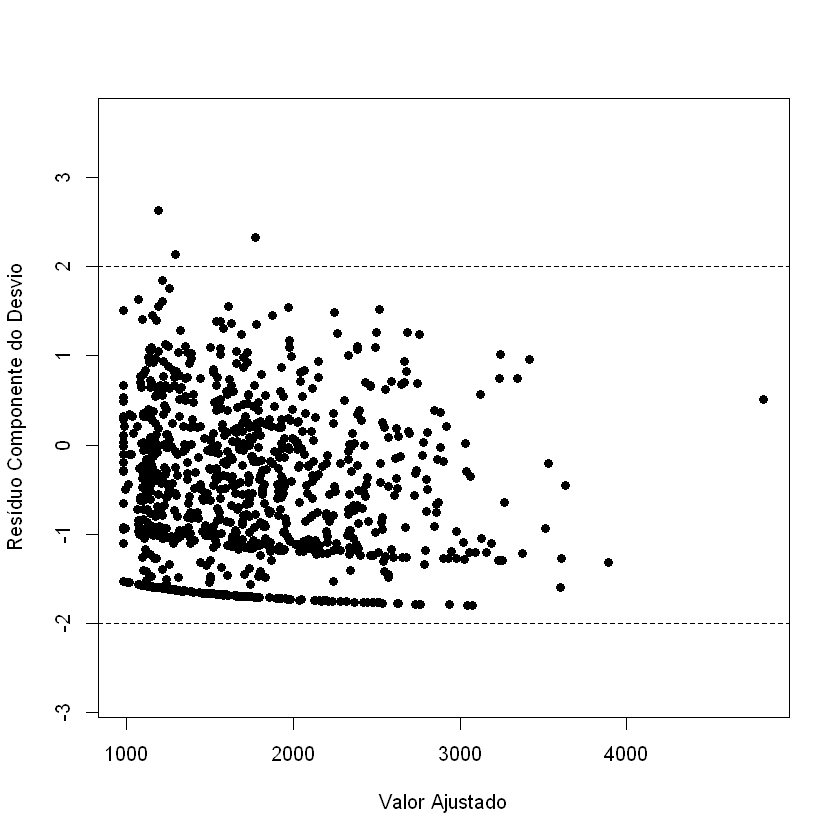

In [313]:
par(bg='white')
plot(fitted(fit.model),td,xlab="Valor Ajustado", ylab="Resíduo Componente do Desvio",
ylim=c(b-1,a+1),pch=16)
abline(2,0,lty=2)
abline(-2,0,lty=2)

#### Envelope

In [288]:
rig <- function(n, mu = stop("no shape arg"), lambda = 1)
{
#  Random variates from inverse Gaussian distribution
#  Reference:
#      Chhikara and Folks, The Inverse Gaussian Distribution,
#      Marcel Dekker, 1989, page 53.
#  GKS  15 Jan 98
#
	if(any(mu<=0)) stop("mu must be positive")
	if(any(lambda<=0)) stop("lambda must be positive")
	if(length(n)>1) n <- length(n)
	if(length(mu)>1 && length(mu)!=n) mu <- rep(mu,length=n)
	if(length(lambda)>1 && length(lambda)!=n) lambda <- rep(lambda,length=n)
	y2 <- rchisq(n,1)
	u <- runif(n)
	r1 <- mu/(2*lambda) * (2*lambda + mu*y2 - sqrt(4*lambda*mu*y2 + mu^2*y2^2))
	r2 <- mu^2/r1
	ifelse(u < mu/(mu+r1), r1, r2)
}

In [289]:
X <- model.matrix(fit.model)
n <- nrow(X)
p <- ncol(X)
w <- fit.model$weights
mu <-predict(fit.model,type="response")
W <- diag(w)
H <- solve(t(X)%*%W%*%X)
H <- sqrt(W)%*%X%*%H%*%t(X)%*%sqrt(W)
h <- diag(H)
ro <- resid(fit.model,type="response")
fi <- (n-p)/sum((ro^2)/(fitted(fit.model)^3))
td <- resid(fit.model,type="deviance")*sqrt(fi/(1-h))
#
e <- matrix(0,n,100)
#
for(i in 1:100){
resp <- rig(n,mu,fi)
fit <- glm(resp ~ X, family=inverse.gaussian(link=log))
w <- fit$weights
W <- diag(w)
H <- solve(t(X)%*%W%*%X)
H <- sqrt(W)%*%X%*%H%*%t(X)%*%sqrt(W)
h <- diag(H)
ro <- resid(fit,type="response")
phi <- (n-p)/sum((ro^2)/(fitted(fit)^3))
e[,i] <- sort(resid(fit,type="deviance")*sqrt(phi/(1-h)))}
#
e1 <- numeric(n)
e2 <- numeric(n)
#
for(i in 1:n){
  eo <- sort(e[i,])
e1[i] <- (eo[2]+eo[3])/2
e2[i] <- (eo[97]+eo[98])/2}

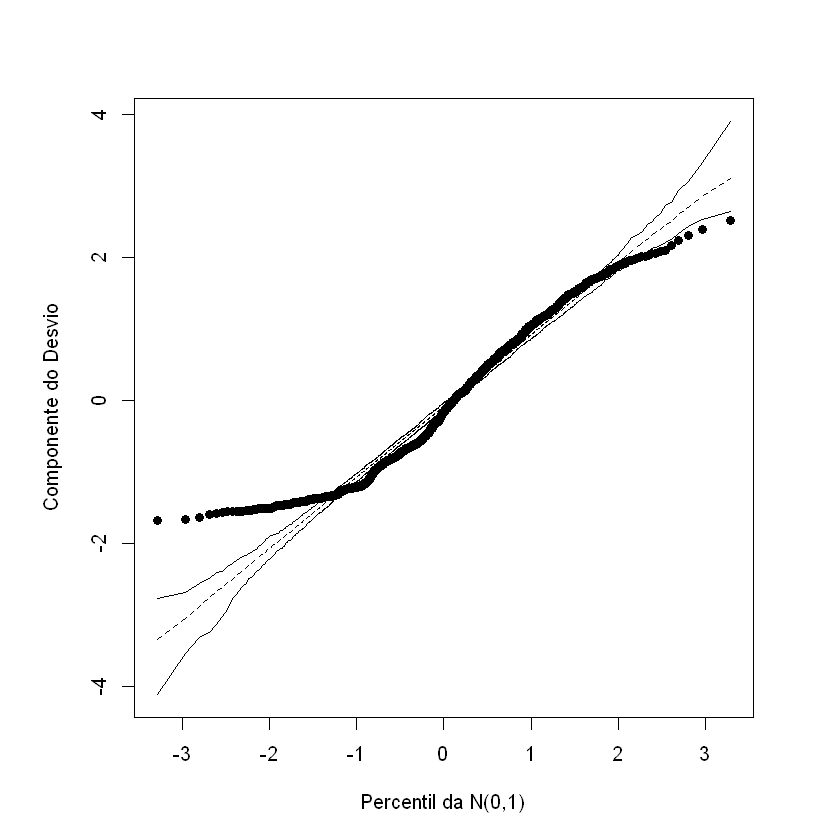

In [290]:
med <- apply(e,1,mean)
faixa <- range(td,e1,e2)
par(pty="s", bg='white')
qqnorm(td,xlab="Percentil da N(0,1)",
ylab="Componente do Desvio", ylim=faixa, pch=16, main="")
par(new=TRUE)
#
qqnorm(e1,axes=F,xlab="",ylab="",type="l",ylim=faixa,lty=1, main="")
par(new=TRUE)
qqnorm(e2,axes=F,xlab="",ylab="", type="l",ylim=faixa,lty=1, main="")
par(new=TRUE)
qqnorm(med,axes=F,xlab="", ylab="", type="l",ylim=faixa,lty=2, main="")

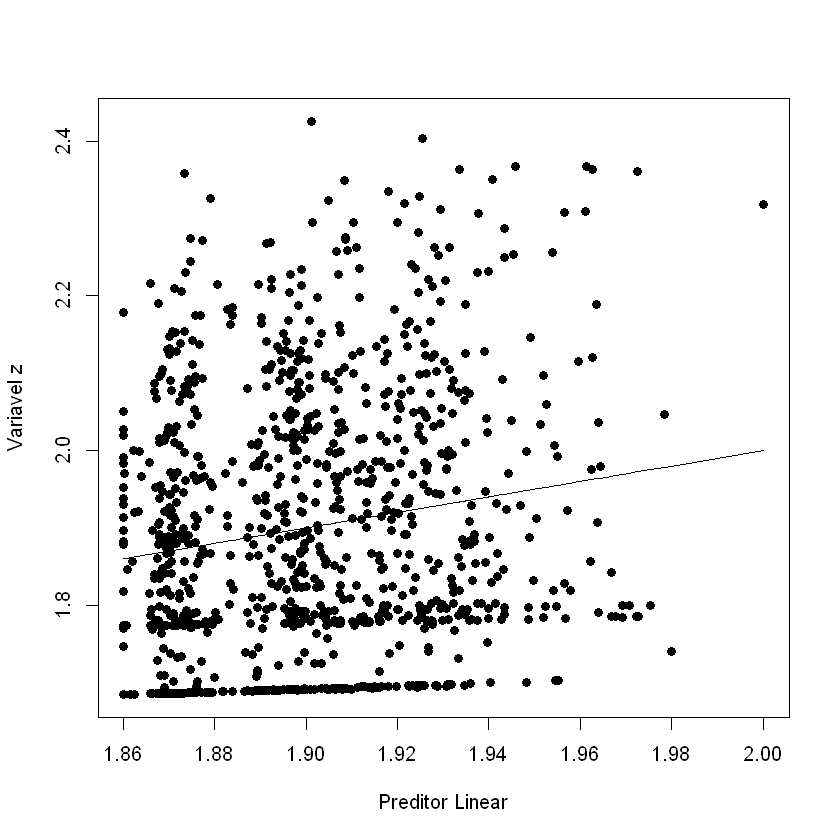

In [291]:
par(bg='white')
eta <- predict(fit.model)
z <- eta + resid(fit.model, type="pearson")/sqrt(w)
plot(predict(fit.model),z,xlab="Preditor Linear",  ylab="Variavel z", pch=16)
lines(smooth.spline(predict(fit.model), z, df=2))

# Modelo Duplo

In [67]:
fit.model = dglm(log(cmsinistros) ~ expos+ tipov, ~expos+valorv, family=inverse.gaussian(link=inverse))
summary(fit.model)


Call: dglm(formula = log(cmsinistros) ~ expos + tipov, dformula = ~expos + 
    valorv, family = inverse.gaussian(link = inverse))

Mean Coefficients:
                Estimate  Std. Error   t value    Pr(>|t|)
(Intercept)  0.143526078 0.002167778 66.208838 0.000000000
expos        0.011128940 0.003168626  3.512229 0.000464362
tipovTRAB   -0.006433436 0.002192406 -2.934418 0.003418639
(Dispersion Parameters for inverse.gaussian family estimated as below )

    Scaled Null Deviance: 1015.897 on 995 degrees of freedom
Scaled Residual Deviance: 996 on 993 degrees of freedom

Dispersion Coefficients:
              Estimate Std. Error    z value      Pr(>|z|)
(Intercept) -5.0072839 0.13708978 -36.525580 4.354897e-292
expos       -0.5213430 0.17666954  -2.950950  3.167979e-03
valorv      -0.1047229 0.04131252  -2.534896  1.124808e-02
(Dispersion parameter for Gamma family taken to be 2 )

    Scaled Null Deviance: 957.2847 on 995 degrees of freedom
Scaled Residual Deviance: 941.6479 on 993 d

# Análise de Diagnóstico

### Análise de mu

In [68]:
X <- model.matrix(fit.model)
n <- nrow(X)
p <- ncol(X)
library(dglm)
fi <- fitted(fit.model$dispersion)
fi <- 1/fi
w <- fit.model$weights
w <- w*fi
W <- diag(w)
H <- solve(t(X)%*%W%*%X)
H <- sqrt(W)%*%X%*%H%*%t(X)%*%sqrt(W)
h <- diag(H)
ts <- resid(fit.model,type="pearson")*sqrt(fi/(1-h))
td <- resid(fit.model,type="deviance")*sqrt(fi/(1-h))
par(mfrow=c(2,2))
di <- (h/(1-h))*(ts^2)
a <- max(td)
b <- min(td)


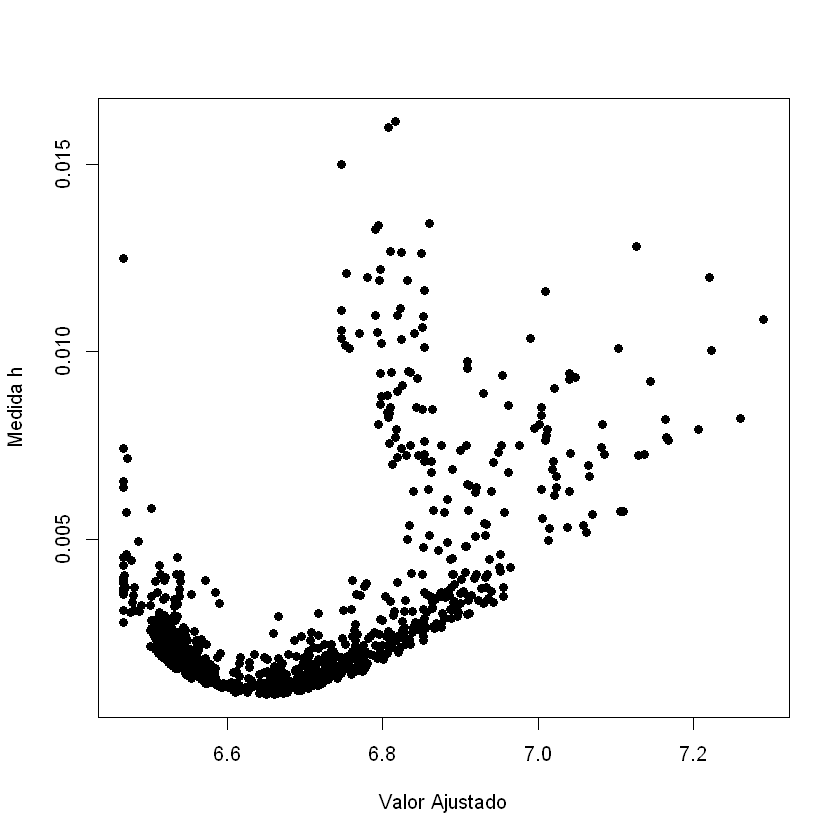

In [69]:
par(bg='white')
plot(fitted(fit.model),h,xlab="Valor Ajustado", ylab="Medida h", pch=16)

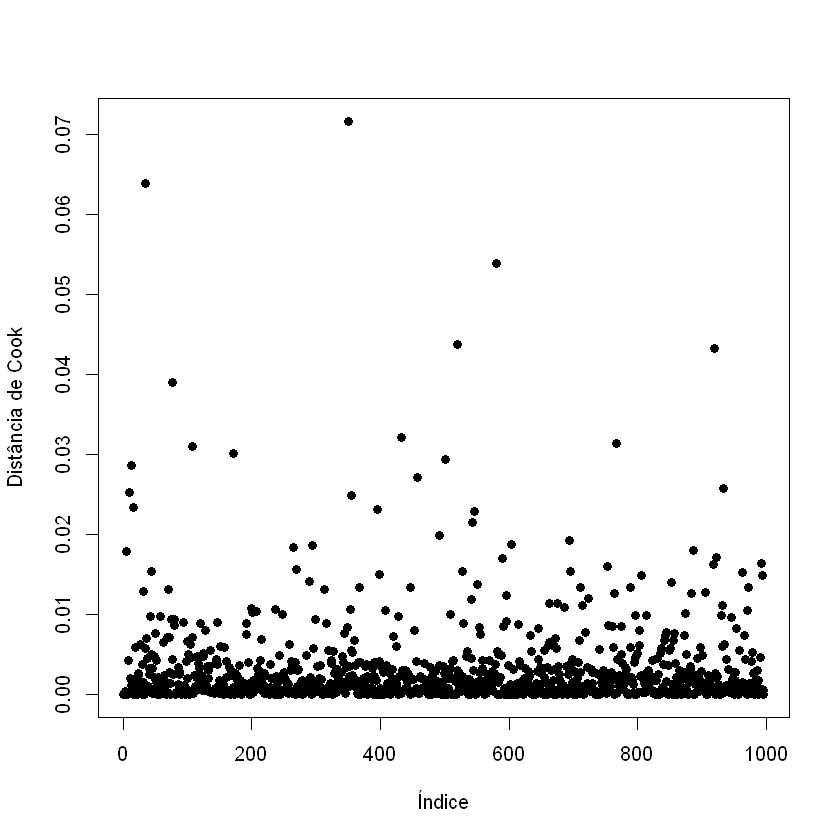

In [70]:
par(bg='white')
plot(di,xlab="Índice", ylab="Distância de Cook", pch=16)

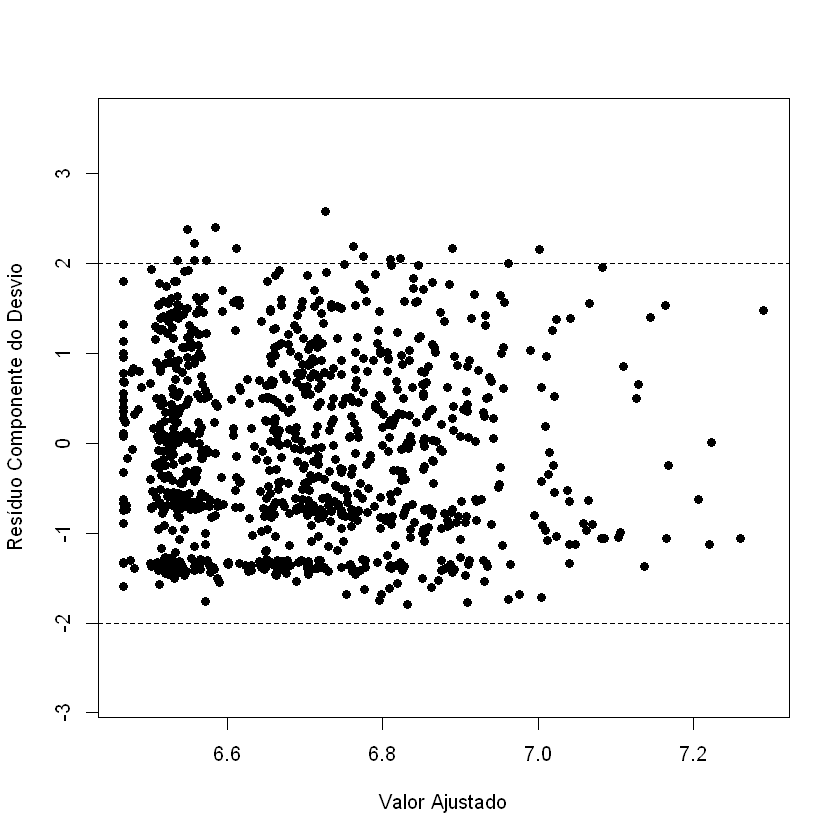

In [71]:
par(bg='white')
plot(fitted(fit.model),td,xlab="Valor Ajustado",  ylab="Resíduo Componente do Desvio", ylim=c(b-1,a+1),pch=16)
abline(2,0,lty=2)
abline(-2,0,lty=2)

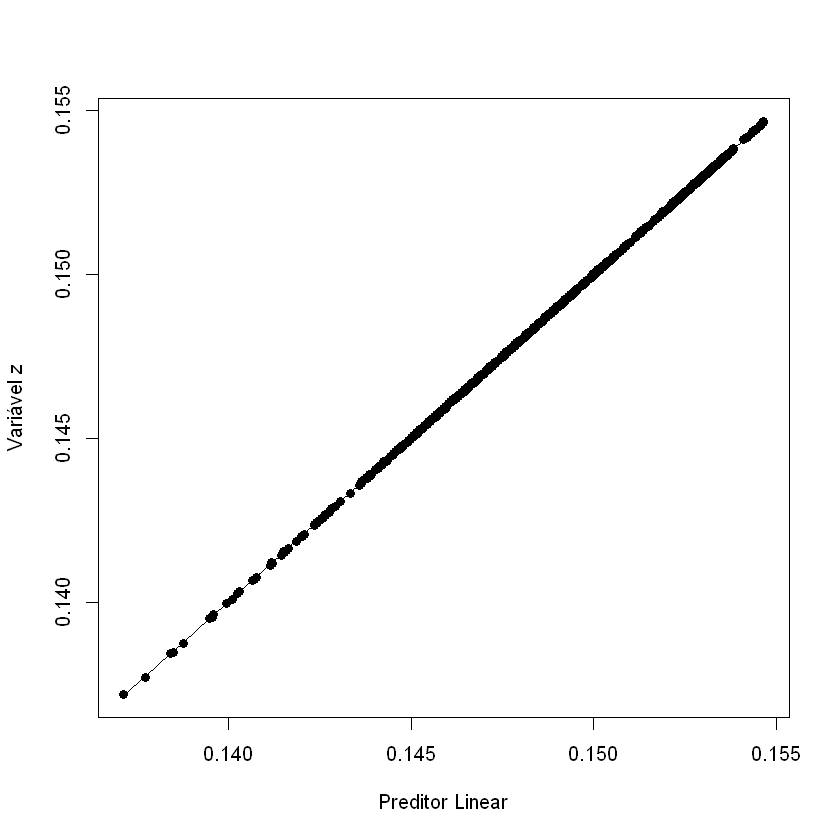

In [72]:
par(bg='white')
eta <- predict(fit.model)
z <- eta + resid(fit.model, type="pearson")/sqrt(w)
plot(predict(fit.model),z,xlab="Preditor Linear",  ylab="Variável z", pch=16)
lines(smooth.spline(predict(fit.model), z, df=2))

### Análise do Parâmetro de Dispersão

In [73]:
X <- model.matrix(fit.model)
n <- nrow(X)
p <- ncol(X)
Z=X
library(dglm)
mu <- fitted(fit.model)
resp <- fit.model$y
fi <- fitted(fit.model$dispersion)
fi <- 1/fi
R <- solve(t(Z)%*%Z)
R <- Z%*%R%*%t(Z)
r <- diag(R)
t <- -(resp/(2*mu*mu) + 1/mu + 1/(2*mu))
t1 = t + 1/(2*fi)
tt = t1/(sqrt(1-r)*(1/(fi*sqrt(2))))
td <- resid(fit.model$dispersion,type="deviance")/sqrt(1-r)
par(mfrow=c(1,2))
a <- max(td)
b <- min(td)
di = (r/(1-r))*(tt^2)

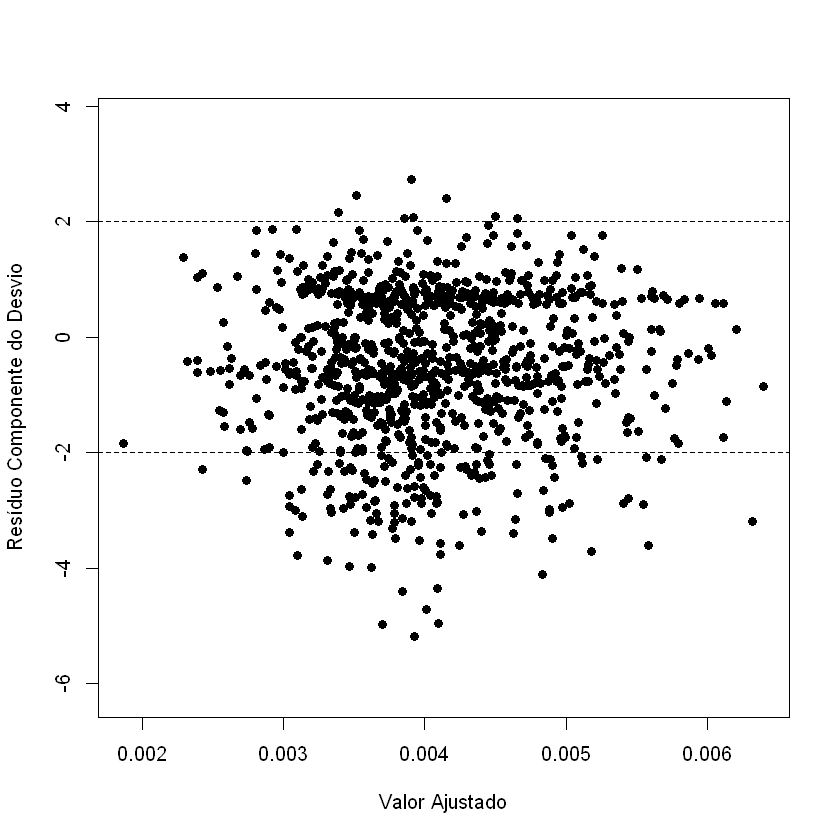

In [74]:
par(bg='white')
plot(fitted(fit.model$dispersion),td,xlab="Valor Ajustado", 
ylab="Resíduo Componente do Desvio",ylim=c(b-1,a+1),pch=16)
abline(2,0,lty=2)
abline(-2,0,lty=2)

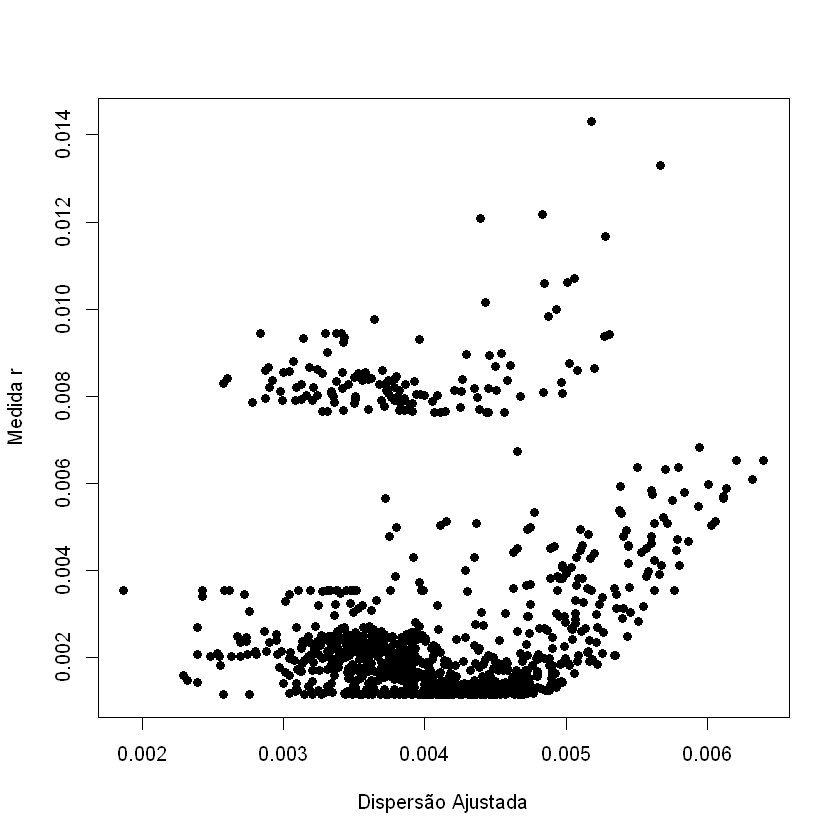

In [75]:
par(bg='white')
plot(fitted(fit.model$dispersion),r,xlab="Dispersão Ajustada", ylab="Medida r", pch=16)

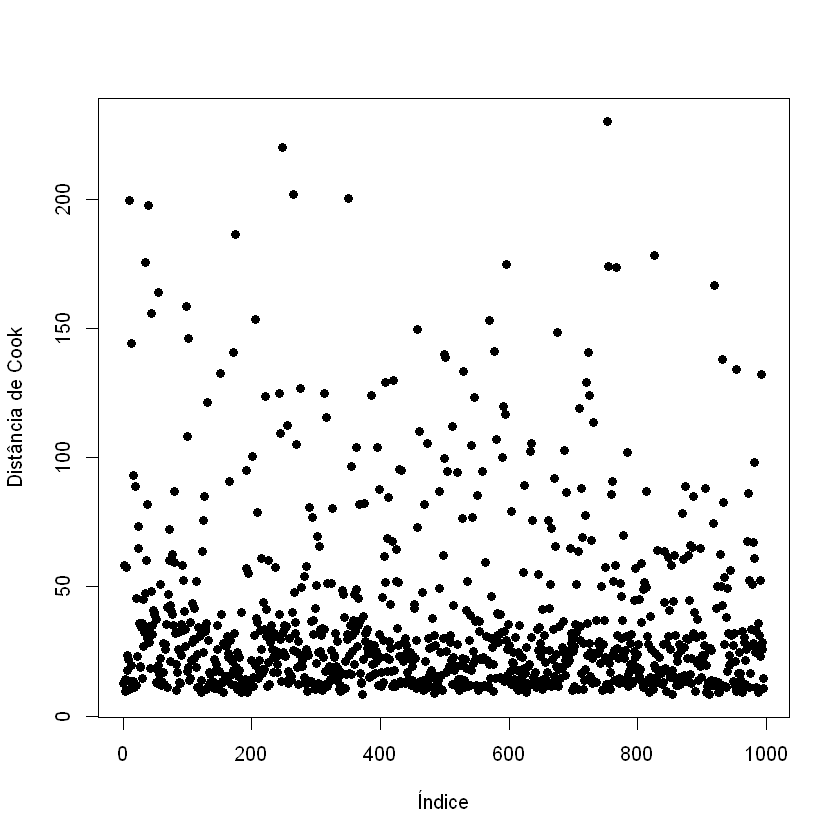

In [76]:
par(bg='white')
plot(di,xlab="Índice", ylab="Distância de Cook", pch=16)

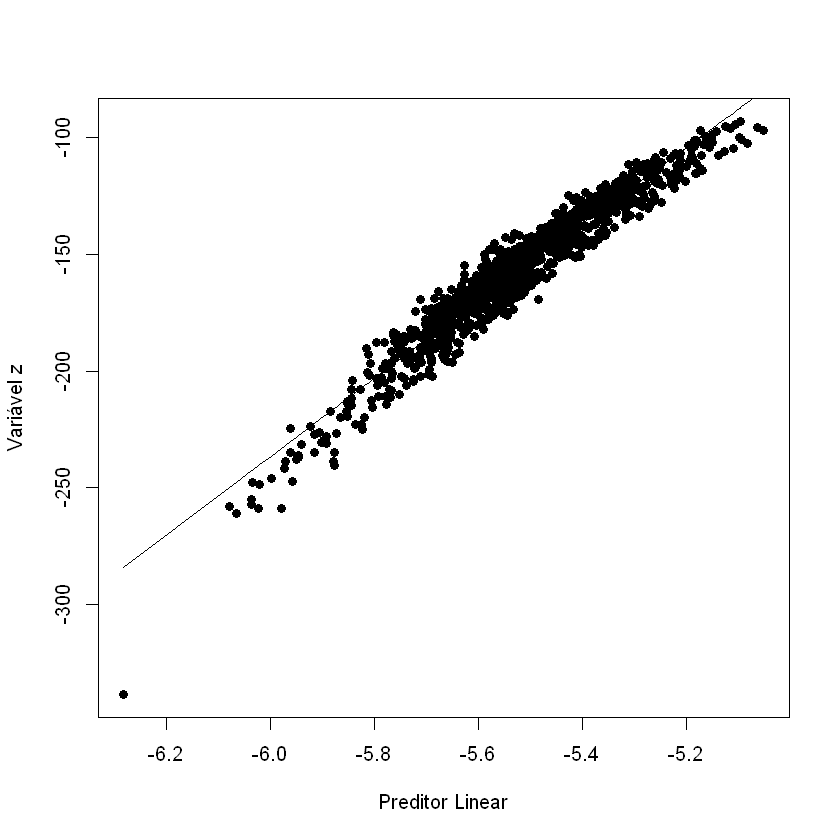

In [77]:
par(bg='white')
eta <- predict(fit.model$dispersion)
z <- eta +  2*fi*t1    
plot(eta,z,xlab="Preditor Linear", 
ylab="Variável z", pch=16)
lines(smooth.spline(predict(fit.model$dispersion), z, df=2))


## Envelope

In [64]:
rig <- function(n, mu = stop("no shape arg"), lambda = 1)
{
#  Random variates from inverse Gaussian distribution
#  Reference:
#      Chhikara and Folks, The Inverse Gaussian Distribution,
#      Marcel Dekker, 1989, page 53.
#  GKS  15 Jan 98
#
	if(any(mu<=0)) stop("mu must be positive")
	if(any(lambda<=0)) stop("lambda must be positive")
	if(length(n)>1) n <- length(n)
	if(length(mu)>1 && length(mu)!=n) mu <- rep(mu,length=n)
	if(length(lambda)>1 && length(lambda)!=n) lambda <- rep(lambda,length=n)
	y2 <- rchisq(n,1)
	u <- runif(n)
	r1 <- mu/(2*lambda) * (2*lambda + mu*y2 - sqrt(4*lambda*mu*y2 + mu^2*y2^2))
	r2 <- mu^2/r1
	ifelse(u < mu/(mu+r1), r1, r2)
}

In [65]:
X <- model.matrix(fit.model)
n <- nrow(X)
p <- ncol(X)
Z=X
require(dglm)
mu <- fitted(fit.model)
fi <- fitted(fit.model$dispersion)
fi <- 1/fi
R <- solve(t(Z)%*%Z)
R <- Z%*%R%*%t(Z)
r <- diag(R)
td <- resid(fit.model$dispersion,type="deviance")/sqrt(1-r)
#
e <- matrix(0,n,100)
#
for(i in 1:100){
resp <- rig(n,mu,fi)
fit <- dglm(resp ~ X, ~ Z, family=inverse.gaussian(link=log))
e[,i] <- sort(resid(fit$dispersion,type="deviance")/sqrt(1-r))}
#
e1 <- numeric(n)
e2 <- numeric(n)
#
for(i in 1:n){
  eo <- sort(e[i,])
e1[i] <- (eo[2]+eo[3])/2
e2[i] <- (eo[97]+eo[98])/2}

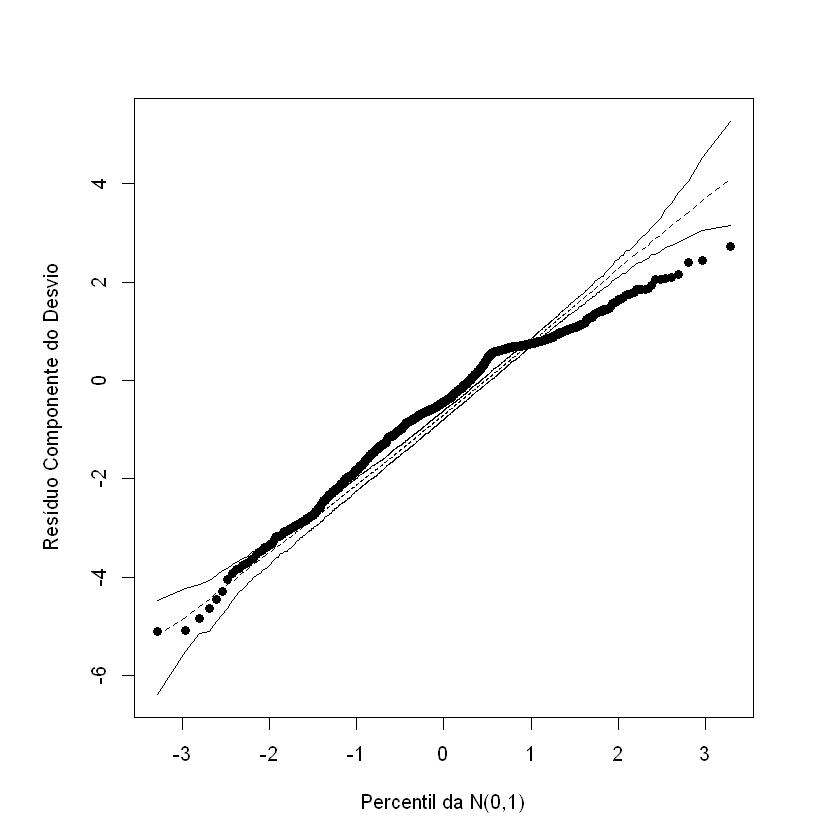

In [66]:

med <- apply(e,1,mean)
faixa <- range(td,e1,e2)
par(pty="s", bg='white')
qqnorm(td, xlab="Percentil da N(0,1)",
ylab="Resíduo Componente do Desvio", ylim=faixa, pch=16, main="")
par(new=TRUE)
#
qqnorm(e1,axes=F,xlab="",ylab="",type="l",ylim=faixa,lty=1, main="")
par(new=TRUE)
qqnorm(e2,axes=F,xlab="",ylab="", type="l",ylim=faixa,lty=1, main="")
par(new=TRUE)
qqnorm(med,axes=F,xlab="", ylab="", type="l",ylim=faixa,lty=2, main="")